# Exp 016: Analyze Performance in Grammar-Controlled Response Generation
This experiment creates descriptive statistics for the evaluation of different models to solve the problem.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import sys
sys.path.append("../source")
import evaluation

[nltk_data] Downloading package punkt to
[nltk_data]     /cluster/home/dglandorf/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
input_file = "task1_test_gpt35_eval.json"
results = pd.read_json(f"../data/{input_file}")
results['num_constraints'] = results['constraints'].apply(len)
results['num_constraints_sat'] = results['positive_constraints'].apply(lambda x: np.count_nonzero(x)) / results['num_constraints']

In [3]:
single_constraints = results[results['num_constraints']==1].copy()
single_constraints['constraint'] = single_constraints['constraints'].apply(lambda x: x[0])
single_constraints['responses0'] = single_constraints['responses'].apply(lambda x: x[0])

In [4]:
def get_aggs(results, by='num_constraints', distinct=False):
    distinct = {'responses0': evaluation.calculate_distinct_n} if distinct else {}
    aggs = results.groupby(by).agg({'num_constraints_sat': ['mean'],
                                    **distinct,
                                    **{col: ['mean', 'count'] for col in results.columns[9:13]}})
    return aggs

In [5]:
get_aggs(single_constraints, ["response_hit"], distinct=True)

num_constraints_sat           responses0 Appropriateness        \
                            mean calculate_distinct_n            mean count   
response_hit                                                                  
0.0                     0.417797             0.552953        3.584746   118   
1.0                     0.514919             0.550074        3.593220   118   

             Relevance       Content Richness       Grammatical Correctness  \
                  mean count             mean count                    mean   
response_hit                                                                  
0.0           3.110169   118         2.906780   118                4.279661   
1.0           3.313559   118         3.161017   118                4.355932   

                    
             count  
response_hit        
0.0            118  
1.0            118

/tmp/ipykernel_38044/3007437695.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{x:.0%}' for x in ax.get_yticks()])


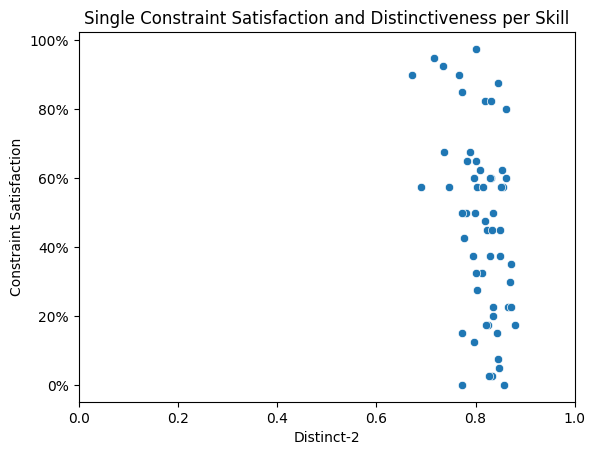

In [12]:
single = get_aggs(single_constraints, ["constraint"], distinct=True)
x=single['responses0']['calculate_distinct_n']
y=single['num_constraints_sat']['mean']
ax = sns.scatterplot(x=x, y=y)
ax.set_ylabel("Constraint Satisfaction")
ax.set_xlabel("Distinct-2")
ax.set_title("Single Constraint Satisfaction and Distinctiveness per Skill")
ax.set_yticklabels([f'{x:.0%}' for x in ax.get_yticks()])
for i, txt in enumerate(single.index):
    #ax.annotate(txt, (x.iloc[i], y.iloc[i]))
    pass
ax.axis(xmin=0.,xmax=1.)
print("")

In [30]:
np.mean(single['responses0']['calculate_distinct_n'])

0.812148311043707

In [8]:
per_num_constraints = get_aggs(results)

In [12]:
per_num_constraints

num_constraints_sat Appropriateness       Relevance        \
                               mean            mean count      mean count   
num_constraints                                                             
1                          0.466213        3.588983   236  3.211864   236   
2                          0.272500        3.357542   179  2.972067   179   
3                          0.183333        3.266667    90  2.977778    90   
4                          0.172500        3.337079    89  3.101124    89   
6                          0.126667        3.280899    89  2.910112    89   

                Content Richness       Grammatical Correctness        
                            mean count                    mean count  
num_constraints                                                       
1                       3.033898   236                4.317797   236  
2                       2.927374   179                4.229050   179  
3                       3.000000    90                4.188889    90  
4                       3.044944    89                4.247191    89  
6                       3.011236    89                4.224719    89

/tmp/ipykernel_15015/3806351919.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()])


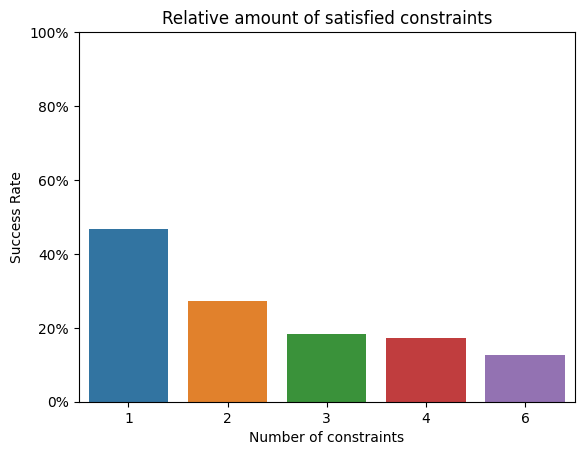

In [26]:
sns.barplot(per_num_constraints, x=per_num_constraints.index, y=per_num_constraints['num_constraints_sat']['mean'])
plt.ylim(0.0,1.0)
plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()])
plt.ylabel("Success Rate")
plt.xlabel("Number of constraints")
plt.title("Relative amount of satisfied constraints")
plt.show()

In [200]:
get_aggs(results, ["n_subcats"])

num_constraints_sat Appropriateness       Relevance        \
                         mean            mean count      mean count   
n_subcats                                                             
1                    0.460457        3.507692   325  3.110769   325   
2                    0.196250        3.379888   179  3.100559   179   
3                    0.155000        3.273743   179  2.944134   179   

          Content Richness       Grammatical Correctness        
                      mean count                    mean count  
n_subcats                                                       
1                 3.000000   325                4.286154   325  
2                 2.994413   179                4.251397   179  
3                 3.005587   179                4.206704   179

In [201]:
get_aggs(results, ["n_subcats","num_constraints"])

num_constraints_sat Appropriateness       Relevance  \
                                         mean            mean count      mean   
n_subcats num_constraints                                                       
1         1                          0.466213        3.588983   236  3.211864   
          2                          0.325000        3.292135    89  2.842697   
2         2                          0.220000        3.422222    90  3.100000   
          4                          0.172500        3.337079    89  3.101124   
3         3                          0.183333        3.266667    90  2.977778   
          6                          0.126667        3.280899    89  2.910112   

                                Content Richness        \
                          count             mean count   
n_subcats num_constraints                                
1         1                 236         3.033898   236   
          2                  89         2.910112    89   
2         2                  90         2.944444    90   
          4                  89         3.044944    89   
3         3                  90         3.000000    90   
          6                  89         3.011236    89   

                          Grammatical Correctness        
                                             mean count  
n_subcats num_constraints                                
1         1                              4.317797   236  
          2                              4.202247    89  
2         2                              4.255556    90  
          4                              4.247191    89  
3         3                              4.188889    90  
          6                              4.224719    89

In [65]:
input_file = "task2_test_gpt35_eval.json"
results = pd.read_json(f"../data/{input_file}")
results['num_categories'] = results['categories'].apply(len)
#results['num_constraints_sat'] = results['positive_constraints'].apply(lambda x: np.count_nonzero(x)) / results['num_constraints']

In [63]:
def categories_satisfied(row):
    df = pd.DataFrame({'score': row['positive_constraints'], 'category': row['positive_categories']})
    return np.mean(df.groupby("category").agg({"score": lambda x: np.count_nonzero(x)})['score'])

In [69]:
results['num_constraints_sat'] = results.apply(categories_satisfied, axis=1)

In [70]:
per_num_constraints = get_aggs(results, 'num_categories')

/tmp/ipykernel_15015/332648669.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()])


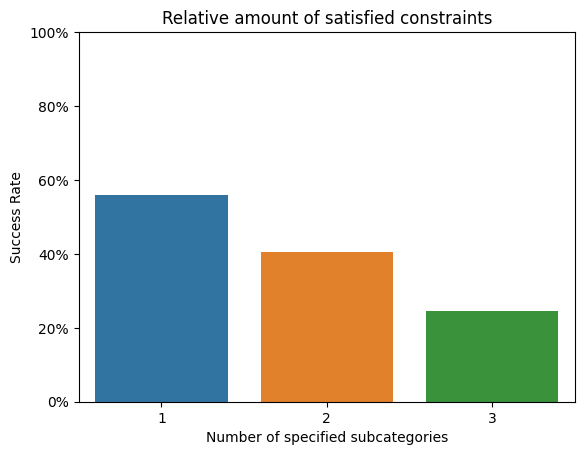

In [72]:
sns.barplot(per_num_constraints, x=per_num_constraints.index, y=per_num_constraints['num_constraints_sat']['mean'])
plt.ylim(0.0,1.0)
plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()])
plt.ylabel("Success Rate")
plt.xlabel("Number of specified subcategories")
plt.title("Relative amount of satisfied constraints")
plt.show()

In [73]:
per_num_constraints

num_constraints_sat Appropriateness       Relevance        \
                              mean            mean count      mean count   
num_categories                                                             
1                         0.560000            3.38   100      2.98   100   
2                         0.403750            3.37   100      2.95   100   
3                         0.244167            3.31   100      2.88   100   

               Content Richness       Grammatical Correctness        
                           mean count                    mean count  
num_categories                                                       
1                          2.82   100                    4.90   100  
2                          2.93   100                    4.88   100  
3                          2.87   100                    4.90   100